## Autoencoders :

In [ ]:
are a specific type of feedforward neural networks where the input is the same as the output.
They compress the input into a lower-dimensional code and then reconstruct the output from this representation.
The code is a compact "summary" or "compression" of the input, also called the latent-space representation.
    
An autoencoder consists of 3 components : encoder, code and decoder. 
The encoder compresses the input and produces the code,
the decoder then reconstructs the input only using this code.
    
Input Image --> Encoder --> Code --> Decoder --> Output Image
        
To build an autoencoder we need 3 things : 
an encoding method, decoding method, and a loss function 
to compare the output with the target. 

Encoder : h=f(x)  , 
Decoder : r=g(h)  ,   
so,  g(f(x))=r , where you want 'r' as close as the original input x.

4 types of Autoencoders : 
1.Vanilla, 2.Multilayer, 3.Convolutional, 4.Regularized : (a.Sparse , b.Denoising ) autoencoder.  

#### Our input image has a dimension of 784, we will encode it to 32 and the decode it back to the original dimension of 784 i.e. output image

<img src="autoencoder1.png">

## -----------------------

#### Import libraries

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

Using TensorFlow backend.


#### load the data

In [58]:
# don't need the labels as the autoencoders are unsupervised network

(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

#### Normalize the data

In [59]:
# We want the pixels values between 0 and 1 instead of between 0 and 255

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [60]:
# Flatten the images for the Fully-Connected Networks

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

## ----------------------------

#### 1.Vanilla autoencoder :         
####  In its simplest form, the autoencoder is a three layers neural network with one hidden layer (Input - encoded - decoded)

In [12]:
input_size = 784            
hidden_size = 64
output_size = 784

In [13]:
# input_img --> encoded --> decoded (output)

input_img = Input(shape=(input_size,))                              # input

encoded = Dense(hidden_size, activation='relu')(input_img)          # encode 

decoder = Dense(output_size, activation='sigmoid')(encoded)         # decode (output)

In [14]:
autoencoder = Model(inputs=input_img, outputs=decoder)   # create the autoencoder  
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [15]:
# We can also extract the encoder which takes input as input images and the output is the encoded image.

encoder = Model(input_img, encoded)

encoded_imgs = encoder.predict(X_test)        # show encoded images

#### Compile and fit the Model

In [18]:
autoencoder.compile(optimizer='adam', loss='mse')

In [19]:
history = autoencoder.fit(X_train, X_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 93us/step - loss: 0.0053 - val_loss: 0.0049
Epoch 2/5
60000/60000 [==============================] - 5s 83us/step - loss: 0.0048 - val_loss: 0.0045
Epoch 3/5
60000/60000 [==============================] - 5s 89us/step - loss: 0.0046 - val_loss: 0.0043
Epoch 4/5
60000/60000 [==============================] - 5s 85us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/5
60000/60000 [==============================] - 5s 85us/step - loss: 0.0043 - val_loss: 0.0041


#### Predict the test set

In [20]:
predict_imgs = autoencoder.predict(X_test)      # shows output (reconstructed images)

#### Plot the images

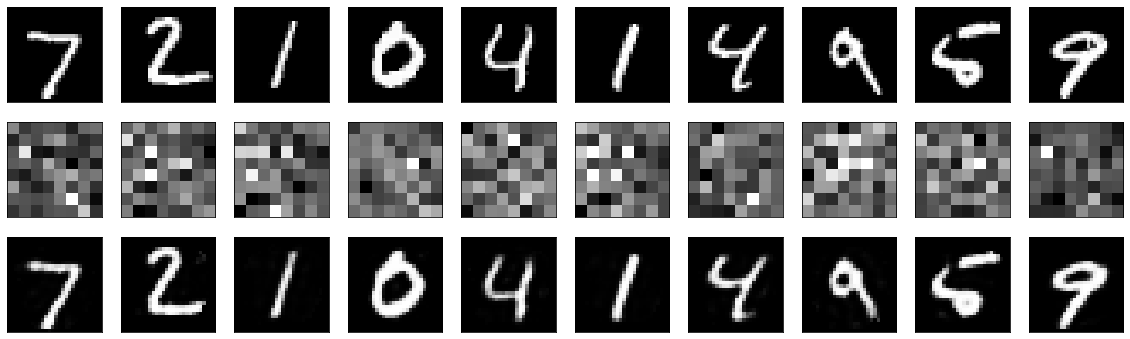

In [32]:
n=10
plt.figure(figsize=(20, 6))
for i in range(n):
    
    ax = plt.subplot(3, n, i+1)                         # display original images
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(3, n, i+1+n)                        # display encoded images
    plt.imshow(encoded_imgs[i].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    ax = plt.subplot(3, n, i+2*n+1)                     # display reconstructed (output) images
    plt.imshow(predict_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

#### Plot the losses

dict_keys(['val_loss', 'loss'])


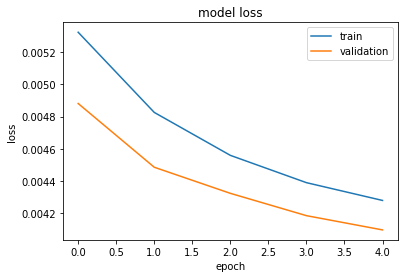

In [33]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## ----------------------------------------

### 2. Multilayer autoencoder : 

#### If one hidden layer is not enough, we can obviously extend the autoencoder to more hidden layers.

In [37]:
input_size = 784
hidden_size = 128
code_size = 64

input_img = Input(shape=(input_size,))                           # input image (784)

hidden_1 = Dense(hidden_size, activation='relu')(input_img)      # encoded to (128)
hidden_2 = Dense(code_size, activation='relu')(hidden_1)         # encode to (64)

hidden_3 = Dense(hidden_size, activation='relu')(hidden_2)      # decoded back to (128)
output = Dense(input_size, activation='sigmoid')(hidden_3)      # reconstructed image (784) output

In [39]:
autoencoder = Model(inputs=input_img, outputs=output)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit the data

In [41]:
autoencoder.compile(optimizer='adadelta', loss='mse')

history = autoencoder.fit(X_train, X_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 178us/step - loss: 0.0237 - val_loss: 0.0227TA: 0s - loss: 0.0
Epoch 2/5
60000/60000 [==============================] - 10s 165us/step - loss: 0.0227 - val_loss: 0.0217ss: 0.022 - ETA: 5s - loss: - ETA: 4s - loss: 0.022 - ETA: 4s - loss: 0.022 - ETA: 4s - loss: 0.022 - ETA: 4s - loss: 0. - ETA: 4s - loss: 0. - ETA: 4s - los - ETA: 3s - ETA: 2s - loss: 0.02 - ETA: 2s  - ETA: 0s - loss: 0
Epoch 3/5
60000/60000 [==============================] - 10s 160us/step - loss: 0.0218 - val_loss: 0.0209oss: 0. - ETA: 1s - loss - ETA: 0s 
Epoch 4/5
60000/60000 [==============================] - 9s 156us/step - loss: 0.0210 - val_loss: 0.0202
Epoch 5/5
60000/60000 [==============================] - 9s 155us/step - loss: 0.0203 - val_loss: 0.0195


### Prediction

In [43]:
encoder = Model(input_img, hidden_2)        # encoded image (784 , 64)

encoded_imgs = encoder.predict(X_test)

In [44]:
predicted_imgs = autoencoder.predict(X_test)        # reconstructed images

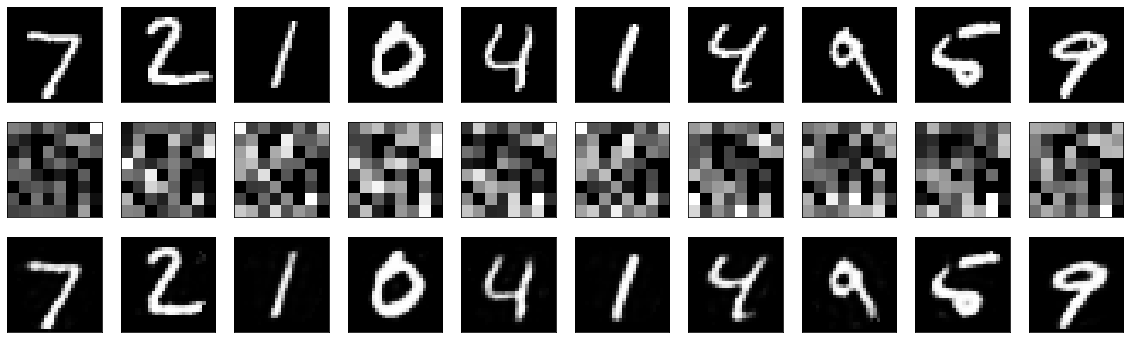

In [45]:
n=10
plt.figure(figsize=(20, 6))
for i in range(n):
    
    ax = plt.subplot(3, n, i+1)                         # display original images
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(3, n, i+1+n)                        # display encoded images
    plt.imshow(encoded_imgs[i].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    ax = plt.subplot(3, n, i+2*n+1)                     # display reconstructed (output) images
    plt.imshow(predict_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


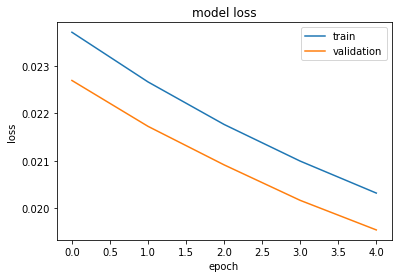

In [46]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## -------------------------------------------------------------------------------------------------

### 3. Convolutional autoencoder : 

##### Can autoencoders be used with Convolutions instead of Fully-connected layers. The answer is 'yes' and the principle is the same, But using images (3D vectors) instead of flattened 1D vectors. The input image is downsampled to give a latent representation of smaller dimensions and force the autoencoder to learn a compressed version of the images.
##### This network does not take flattened vectors as an input but images.

In [47]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [49]:
x = Input(shape=(28, 28,1)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

#### Compile and fit

In [51]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

history = autoencoder.fit(X_train, X_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 242s 4ms/step - loss: 0.2144 - val_loss: 0.1660
Epoch 2/5
60000/60000 [==============================] - 239s 4ms/step - loss: 0.1592 - val_loss: 0.1502
Epoch 3/5
60000/60000 [==============================] - 240s 4ms/step - loss: 0.1452 - val_loss: 0.1409
Epoch 4/5
60000/60000 [==============================] - 241s 4ms/step - loss: 0.1364 - val_loss: 0.1323
Epoch 5/5
60000/60000 [==============================] - 243s 4ms/step - loss: 0.1301 - val_loss: 0.1273


#### Predictions

In [52]:
encoder = Model(x, h)                        # encoded images
encoded_imgs = encoder.predict(X_test)

predicted_imgs = autoencoder.predict(X_test)    # reconstruted images (output)

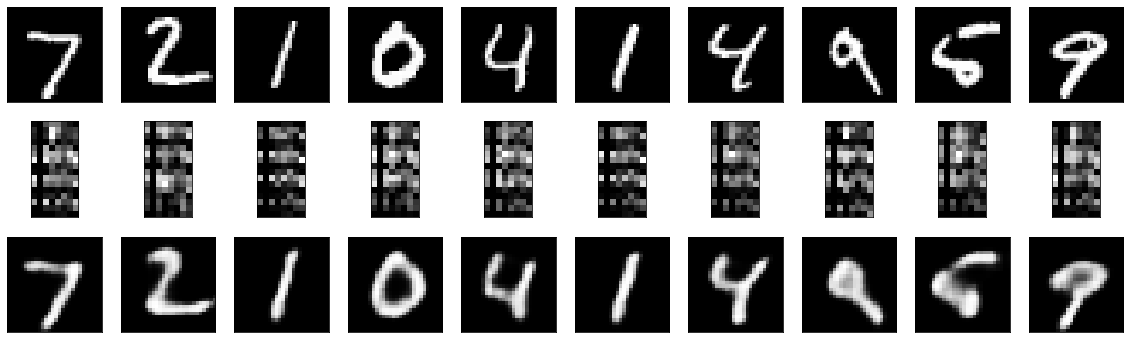

In [54]:
n=10
plt.figure(figsize=(20, 6))
for i in range(n):
    
    ax = plt.subplot(3, n, i+1)                         # display original images
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(3, n, i+1+n)                        # display encoded images 
    plt.imshow(encoded_imgs[i].reshape(16, 8))           # remember the sahpes of images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    ax = plt.subplot(3, n, i+2*n+1)                     # display reconstructed (output) images
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


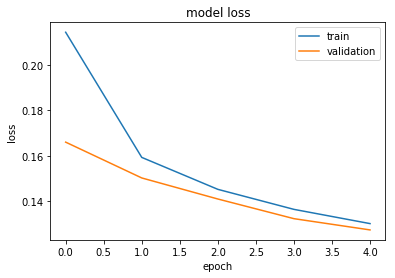

In [55]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## -----------------------------------------------------------------------

### 4. Regularised autoencoder :

In [ ]:
regularized autoencoders use a loss function that encourages the model 
to have other properties besides the ability to copy its input to its output. 
In practice, we usually find two types of regularized autoencoder:
(i) sparse autoencoder.  
(ii) denoising autoencoder.

##### (i).Sparse autoencoder :                          

In [ ]:
Sparse autoencoders are typically used to learn features for another task such as classification.
An autoencoder that has been regularized to be sparse must respond to unique statistical features 
of the dataset it has been trained on, rather than simply acting as an identity function. 
In this way, training to perform the copying task with a sparsity penalty can yield a model 
that has learned useful features as a byproduct.
Another way we can constraint the reconstruction of autoencoder is to impose a constraint in its loss. 
for example, add a reguralization term in the loss function.
Doing this will make autoencoder learn sparse representation of data.

In [69]:
input_size = 784                         # similar to Vanilla (just encoded to 32)
hidden_size = 32
output_size = 784

In [70]:
# Notice in our hidden layer (encoded), we added an l1 activity regularizer, 
# that will apply a penalty to the loss function during the optimization phase. 
# As a result, the representation is now sparser compared to the vanilla autoencoder.

input_img = Input(shape=(input_size,))
encoded = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(output_size, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_22 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


#### compile and fit

In [71]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X_train, X_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.1949 - val_loss: 0.1632
Epoch 2/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.1416 - val_loss: 0.1242
Epoch 3/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1120 - val_loss: 0.1025
Epoch 4/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.0954 - val_loss: 0.0901
Epoch 5/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.0857 - val_loss: 0.0826
Epoch 6/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0798 - val_loss: 0.0779 ETA: 1s - lo - ETA:
Epoch 7/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.0760 - val_loss: 0.0749
Epoch 8/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.0735 - val_loss: 0.0728
Epoch 9/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0718 - 

#### Predictions

In [72]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(X_test)        # show encoded images

predicted_imgs = autoencoder.predict(X_test)      # shows output (reconstructed images)

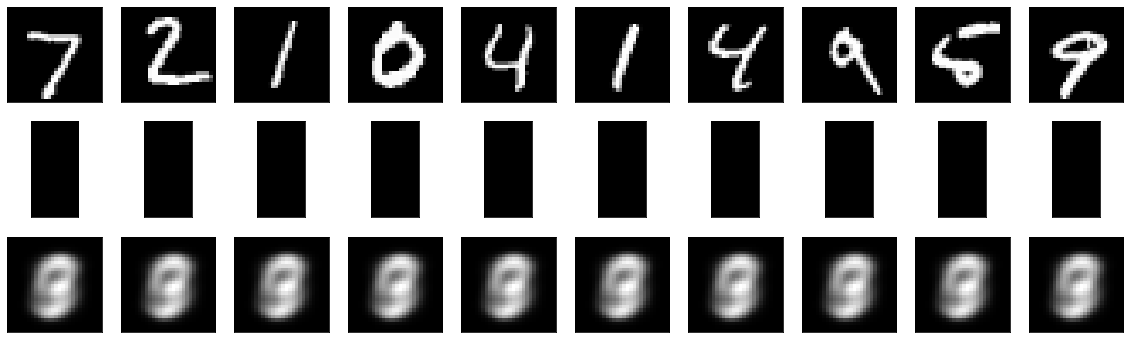

In [73]:
n=10
plt.figure(figsize=(20, 6))
for i in range(n):
    
    ax = plt.subplot(3, n, i+1)                         # display original images
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(3, n, i+1+n)                        # display encoded images
    plt.imshow(encoded_imgs[i].reshape(8, 4))            # 8,4 --> encoded to 32
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    ax = plt.subplot(3, n, i+2*n+1)                     # display reconstructed (output) images
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


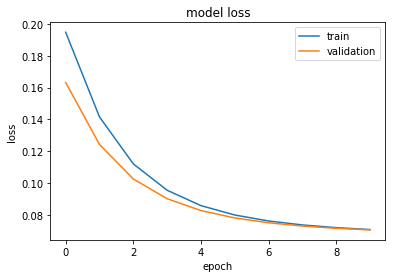

In [74]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## ----------------------------------

#### (ii).Denoising autoencoder :                  

In [ ]:
Rather than adding a penalty to the loss function, we can obtain an autoencoder that 
learns something useful by changing the reconstruction error term of the loss function. 
This can be done by adding some noise of the input image and make the autoencoder learn to remove it. 
By this, the encoder will extract the most important features and learn a robust representation of the data.

In [75]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

#### Create noisy data

In [76]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [77]:
x = Input(shape=(28, 28, 1))

# Encoder
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
h = MaxPooling2D((2, 2), padding='same')(conv1_2)


# Decoder
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
__________

#### compile and fit the data

In [78]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

history = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=3, verbose=1, validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 1164s 19ms/step - loss: 0.1759 - val_loss: 0.1219
Epoch 2/3
60000/60000 [==============================] - 1236s 21ms/step - loss: 0.1181 - val_loss: 0.1120
Epoch 3/3
60000/60000 [==============================] - 786s 13ms/step - loss: 0.1109 - val_loss: 0.1058


#### Predictions

In [79]:
encoder = Model(x, h)
encoded_imgs = encoder.predict(X_test_noisy)        # encoded images

decoded_imgs = autoencoder.predict(X_test_noisy)    # reconstructed images

#### plotting the original, noised image, encoded image and the reconstructed image

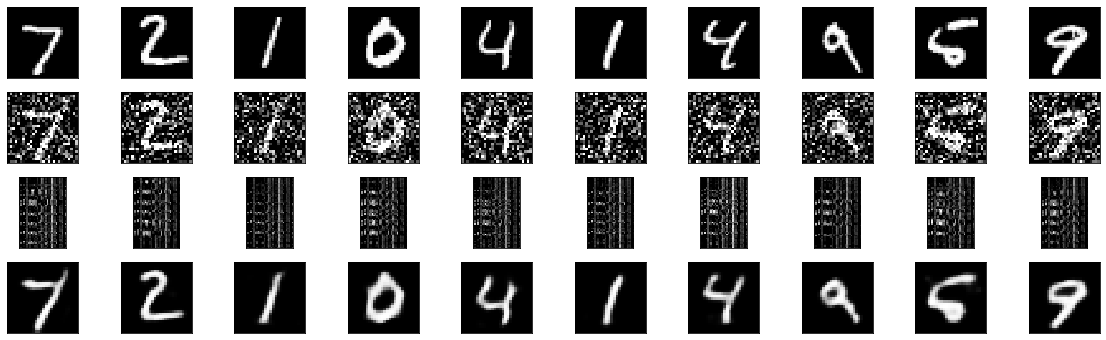

In [100]:
n=10
plt.figure(figsize=(20,6))
for i in range(n):

    ax = plt.subplot(4, n, i + 1)                  # shows original images    
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i+1+n)                 # shows noised images    
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, 2*n+i + 1 )              # shows encoded images    
    plt.imshow(encoded_imgs[i].reshape(49,32))      # remember the shape of aaray
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, 3*n +i+ 1)                 # shows reconstructed images
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()

dict_keys(['val_loss', 'loss'])


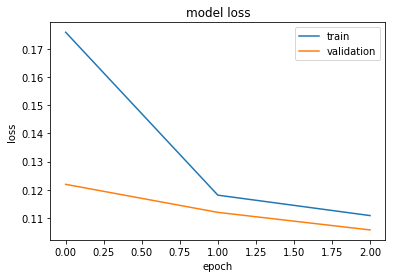

In [101]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()